In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Imports

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [1]:
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft,fftfreq

In [4]:
dataset = pd.read_csv('training-a.csv')

In [5]:
labels = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
raw_data = dataset.drop(['label'],axis=1)

In [6]:
labels.shape

(409,)

## Traitement

Les features qui nous intéressent sont (en mean et std): <br>
**time domain** RR intervals, S1, S2, systolic, diastolic, systolic/RR, diastolic/RR, systolic/diastolic, amplitude systole/S1, amplitude diastole/S2, skewness et kurtosis des amplitudes dans chaque phase<br>
**frequency domain** median and mean power across 9 frequency bands (ranging from 25 to 400Hz), *MFCC features*

Pour des raisons de simplicité, on va faire commencer la segmentation sur une S1.

In [130]:
phases_list = ['S1','S2','systole','diastole']

In [172]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)])-np.mean(signal) #on ignore les NaN et on recentre le signal
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        mask = E>local_max/5
        mask2 = np.abs(E-m)>s/2
        mask3 = E>np.mean(E)*2
        return E*mask
    
    
    def consec_count(self):
        e = self.envelogram()
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.envelogram()
        count_vec = self.consec_count() # le vecteur de comptage associé
        length_threshold = 50
        beat_mask = count_vec<=length_threshold
        systole_mask = count_vec>length_threshold
        segmentation = np.asarray([])
        mean_beat_length = 0
        beat_counter = 0
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            next_stop = i
            while stop < count_vec.shape[0] and next_stop-stop<0.050*self.fs:
                stop = next_stop
                #on calcule la longueur du pic
                while stop<count_vec.shape[0] and beat_mask[stop]:
                    stop+=1

                #on calcule l'écart avec le pic suivant, pour voir s'il s'agit du même pic
                next_stop = stop
                while next_stop<count_vec.shape[0] and not beat_mask[next_stop]:
                    next_stop +=1
                
            #un battement long est un battement S1
            if stop-i>mean_beat_length:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                current_seq = {'beat':'S1','passive':'systole'}
                
            #un battement court est un battement S2
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                current_seq = {'beat':'S2','passive':'diastole'}
                
            #update beat length and parser
            mean_beat_length = np.average([stop-i,mean_beat_length],weights=[1,beat_counter])
            beat_counter += 1
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
                
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            #update parser
            i = stop
        
        #on supprime tout ce qui est avant la première phase S1: 
        j = 0 
        while segmentation[j]!='S1':
            j += 1
            
        return segmentation[j:],E[j:],j
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)[res!=0]
        return np.mean(res),np.std(res)
    
    def timeFeatures(self,segmentation):
        sysRR = [] #rapport durée systole/durée battement
        diaRR = [] #rapport durée diastole/durée battement
        sysdia = [] # rapport durée systole/durée diastole
        start = 0
        bound = len(segmentation)
        #on commence sur la première phase S1
        while segmentation[start]!='S1':
            start+=1
        #on parcourt toute la segmentation
        while start<bound:
            parser = start
            # on attend d'arriver à la première systole
            while parser<bound and segmentation[parser]!='systole':
                parser += 1
            psys = parser
            # on mesure la taille de la systole
            while psys<bound and segmentation[psys]=='systole':
                psys += 1
            systole_length = psys - parser
            parser = psys
            #on mesure la (les) diastole(s)
            diastole_length_list=[]
            while parser<bound and segmentation[parser]!='S1': #la fin du cycle est marquée par le début d'un nouveau S1
                while parser<bound and segmentation[parser]=='S2':#un S2 précède toujours une diastole
                    parser+=1
                pd = parser
                while pd<bound and segmentation[pd]=='diastole': #on mesure la diastole
                    pd += 1
                diastole_length_list.append(pd-parser)
                parser = pd
                
            #grandeurs extraites
            beat_length = parser - start
            sysRR.append(systole_length/beat_length)
            diaRR.append(sum(diastole_length_list)/beat_length)
            if sum(diastole_length_list)!=0:
                sysdia.append(systole_length/sum(diastole_length_list))
            #update start
            start = parser
        sysRR = np.array(sysRR)
        diaRR = np.array(diaRR)
        sysdia = np.array(sysdia)
            
        return np.mean(sysRR),np.std(sysRR),np.mean(diaRR),np.std(diaRR),np.mean(sysdia),np.std(sysdia)
    
        
    def extractFeatures(self):
        segmentation, E,lag = self.segmentation()
        features = np.array([])
        #time features
        for phase in phases_list:
            mean,std = self.timeLengths(segmentation,phase)
            features = np.append(features,[mean,std])
        mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia = self.timeFeatures(segmentation)
        features = np.append(features,[mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia])
       
        #peak features    
        p_S1 = []
        p_S2 = []
        borne = []
        
        for i in range(len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        
        #Skewness et Kurtosis
        skew_S1 = []
        skew_S2 = []
        skew_sys = []
        skew_dis = []
        kur_S1 = []
        kur_S2 = []
        kur_sys = []
        kur_dis = []
        
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == 'S1':
                skew1 = skew(E[borne[i]:borne[i+1]])
                skew_S1.append(skew1) 
                kur1 = kurtosis(E[borne[i]:borne[i+1]])
                kur_S1.append(kur1)    
            if segmentation[borne[i]] == 'S2':
                skew2 = skew(E[borne[i]:borne[i+1]])
                skew_S2.append(skew2) 
                kur2 = kurtosis(E[borne[i]:borne[i+1]])
                kur_S2.append(kur2) 
            if segmentation[borne[i]] == 'diastole':
                skewdis = skew(E[borne[i]:borne[i+1]])
                skew_dis.append(skew_dis) 
                kurdis = kurtosis(E[borne[i]:borne[i+1]])
                kur_dis.append(kurdis) 
            if segmentation[borne[i]] == 'systole':
                skewsys = skew(E[borne[i]:borne[i+1]])
                skew_sys.append(skewsys) 
                kursys = kurtosis(E[borne[i]:borne[i+1]])
                kur_sys.append(kursys)

        features = np.append(features,[np.mean(skew_S1),np.min(skew_S1),np.max(skew_S1),np.std(skew_S1)])
        features = np.append(features,[np.mean(skew_S2),np.min(skew_S2),np.max(kur_S2),np.std(skew_S2)])
        features = np.append(features,[np.mean(0),np.min(0),np.max(0),np.std(0)])
        features = np.append(features,[np.mean(0),np.min(0),np.max(0),np.std(0)])
        
        features = np.append(features,[np.mean(kur_S1),np.min(kur_S1),np.max(kur_S1),np.std(kur_S1)])
        features = np.append(features,[np.mean(kur_S2),np.min(kur_S2),np.max(kur_S2),np.std(kur_S2)])
        features = np.append(features,[np.mean(0),np.min(0),np.max(0),np.std(0)])
        features = np.append(features,[np.mean(0),np.min(0),np.max(0),np.std(0)])
        
        #mean12 feature
        features = np.append(features,max(features[8],features[12]))
        
        #spectral features
        frequency_bands = np.array([0,25,40,60,90,120,160,250,400])
        freqs, psd = welch(self.signal[decalage:])
        band_spectral_power = []
        for i in range(frequency_bands.shape[0]-1):
            band_spectral_power.append(np.sum(psd[freqs in frequency_bands[i:i+1]]))
        features = np.append(features,band_spectral_power)
        
        return features

## Visualisation

In [124]:
time_length = 10000
sample = raw_data.loc[5][:time_length]

In [125]:
pcg = PCG(sample)
segmentation,E,lag = pcg.segmentation()

Text(0,0.5,'amplitude normalisée')

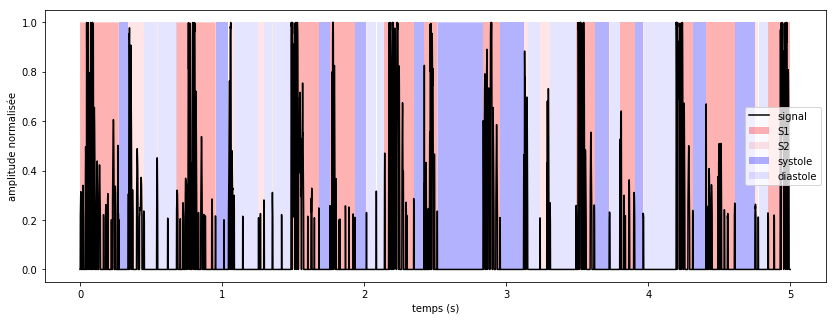

In [126]:
plt.figure(figsize=(14,5))
l = time_length-lag
x = np.linspace(0,l/2000,l)
plt.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
plt.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
plt.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
plt.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')

plt.plot(x,E/np.max(E),'k',label='signal')
plt.legend()
plt.xlabel('temps (s)')
plt.ylabel('amplitude normalisée')

## Analyse des features

In [173]:
sample = raw_data.loc[1]
pcg = PCG(sample)
ft = pcg.extractFeatures()
ft.shape

(47,)

In [17]:
n_samples = raw_data.shape[0]

In [138]:
X = np.zeros(55)
final_labels = []
for i in range(100):
    try:
        start = time.time()
        sample = raw_data.loc[i]
        pcg = PCG(sample)
        ft = pcg.extractFeatures()
        X = np.row_stack((X,ft))
        final_labels.append(labels[i])
        end = time.time()
    except:
        print('il y a une erreur avec le sample %d'%i)
X = X[1:]

temps de calcul: 2.616036
temps de calcul: 2.393259
temps de calcul: 2.447587
temps de calcul: 2.042967
temps de calcul: 2.576498
temps de calcul: 2.407251
temps de calcul: 1.351703
temps de calcul: 2.839275
temps de calcul: 2.087752
temps de calcul: 1.307002
temps de calcul: 1.130055
temps de calcul: 2.155303
temps de calcul: 2.280642
temps de calcul: 2.234580
temps de calcul: 2.363996
temps de calcul: 1.262478
temps de calcul: 2.329207
temps de calcul: 2.073563
temps de calcul: 2.273027
temps de calcul: 2.801579
temps de calcul: 2.062781
temps de calcul: 1.199414
temps de calcul: 1.962700
temps de calcul: 2.111149
temps de calcul: 2.604302
temps de calcul: 2.619977
temps de calcul: 2.359713
temps de calcul: 2.310642
temps de calcul: 2.237647
temps de calcul: 2.727547
temps de calcul: 2.523917
temps de calcul: 2.489461
temps de calcul: 2.285854
temps de calcul: 2.253953
temps de calcul: 0.734821
temps de calcul: 1.896819
temps de calcul: 2.313353
temps de calcul: 2.752918
temps de cal

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


il y a une erreur avec le sample 64
temps de calcul: 2.084796
temps de calcul: 2.362629
temps de calcul: 2.308112
temps de calcul: 1.845041
temps de calcul: 2.170664
temps de calcul: 2.069315
temps de calcul: 2.783133
temps de calcul: 2.617615
temps de calcul: 2.213738
temps de calcul: 2.258284
temps de calcul: 2.130970
temps de calcul: 2.137686
temps de calcul: 2.178585
temps de calcul: 2.106985
temps de calcul: 2.728290
temps de calcul: 1.350079
temps de calcul: 1.929937
temps de calcul: 2.198541
temps de calcul: 1.170144
temps de calcul: 2.266463
temps de calcul: 1.202630
temps de calcul: 2.131959
temps de calcul: 2.229411
temps de calcul: 2.697563
temps de calcul: 2.274882
temps de calcul: 2.450734
temps de calcul: 2.085478
temps de calcul: 2.394115
temps de calcul: 2.218490
temps de calcul: 2.117236
temps de calcul: 2.202301
temps de calcul: 2.303416
temps de calcul: 2.487106
temps de calcul: 2.235721
temps de calcul: 2.030584


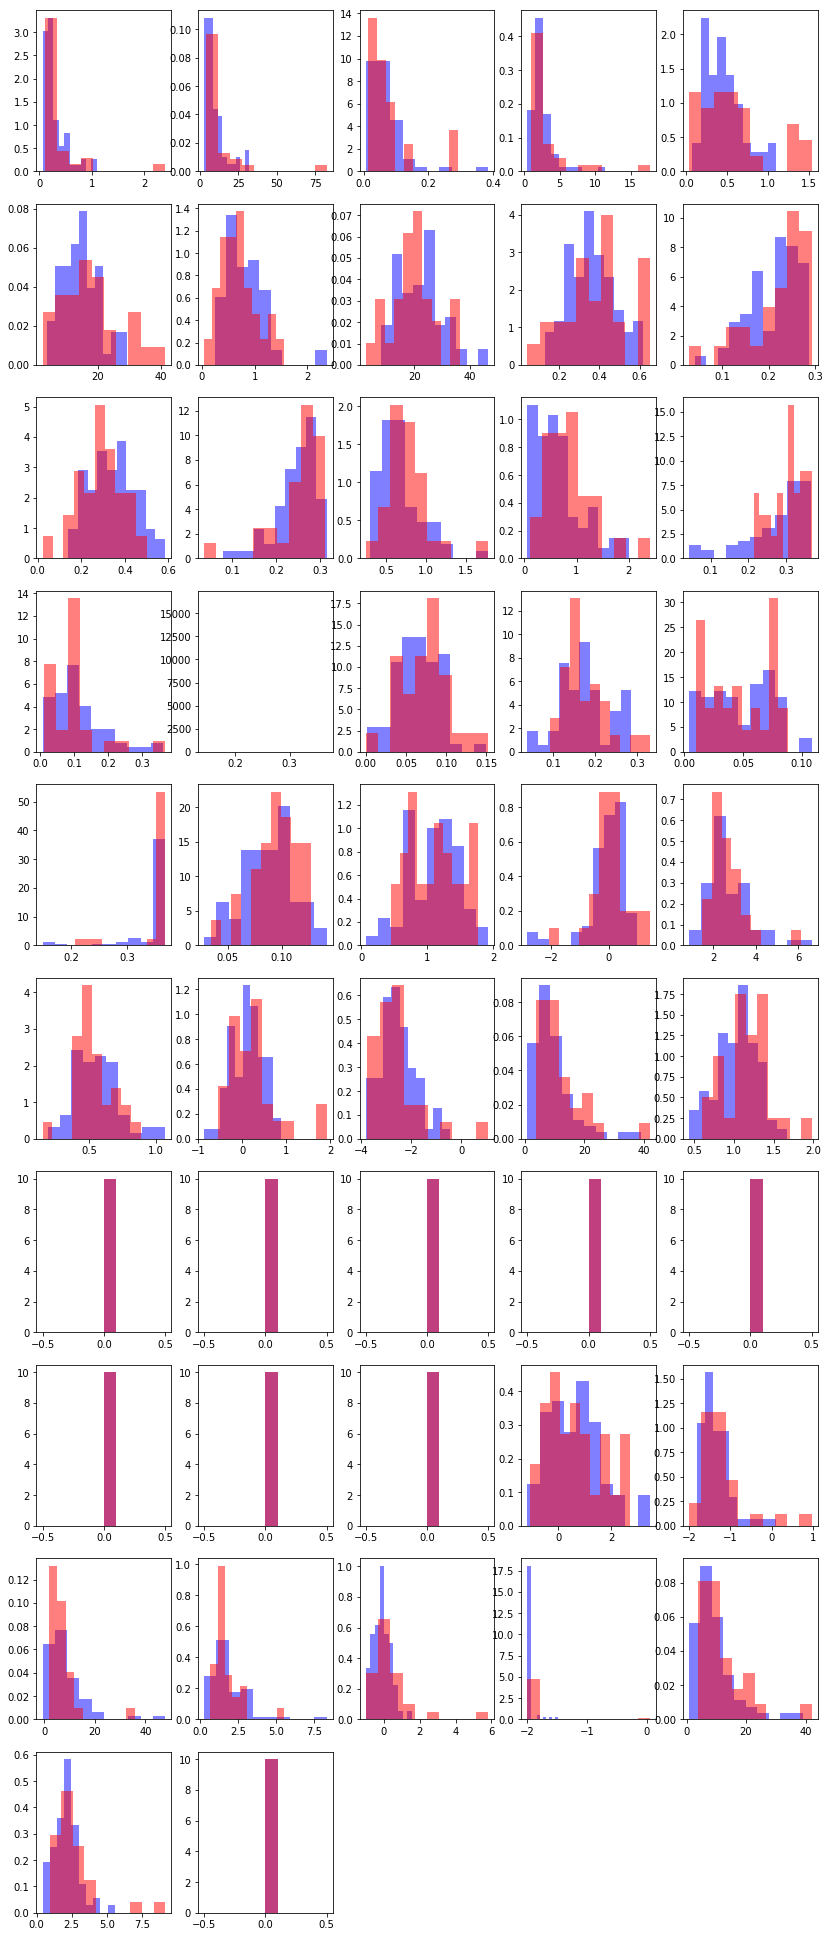

In [174]:
fig = plt.figure(figsize=(14,35))
X = np.asarray(X)
final_labels = np.array(final_labels)
for i in range(47):
    ax = fig.add_subplot(10,5,i+1)
    ft = X[:,i]
    #print(ft)
    normalft = ft[final_labels==1]
    anormalft = ft[final_labels==-1]
    ax.hist(normalft,density=True,color='b',alpha=0.5)
    ax.hist(anormalft,density=True,color='r',alpha=0.5)

## Classification

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [ ]:
np.random.seed(0)

In [36]:
pca = PCA(n_components = 10)
X_red = pca.fit_transform(features)

In [70]:
rf = RandomForestClassifier(n_estimators=10,max_depth=2)
svm = SVC(C=100,gamma=100)
nn = MLPClassifier()
logit = LogisticRegression()
for clf in [logit,rf,svm,nn]:
    print(cross_val_score(rf,features,final_labels,cv=2))

[0.69117647 0.70792079]
[0.69607843 0.6980198 ]
[0.71078431 0.72277228]
[0.70098039 0.71287129]
